# Fitting Saturation-based Simulation Data
In this notebook, we try to fit intensity data generated using a saturation based method. The mu_a for each of the maternal and fetal layer are based on a set oxygen saturation and HB concentration. The impact of all other pigments on mu_a are ignored. The goal for this experiment is to see if we can train a model to determine these hidden variables - the Hb conc. and the saturation just by looking at the intensity values!

# Instructions
I have the parameter search in one of the cells. Run eveerything above it to be able to run that cell.
If you don't want to search, ignore that cell and run everything above and below. 

# Issues
1. Only the mu_a's are changed, not any of the other properties! 
2. Fetal performance is not nearly as good as maternal. This could be due to the noise in the far ends of the plots. Maybe interpolation would help?
3. Fetal errors: Sat: ~3% Sat., Conc: ~1.9


# Notes
1. Using interpolated values seems to make the fitting more stable. Not better however.
2. Maternal is very good.
3. Fetal just estimates a mean!

# Things to Try
1. Fetal | Maternal = known
2. CNN

In [1]:
from torch.optim import Adam, SGD
import torch.nn as nn
import torch
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn import preprocessing
from inverse_modelling_tfo.models import train_model, create_perceptron_model, train_model_wtih_reporting
from inverse_modelling_tfo.data import generate_data_loaders, equidistance_detector_normalization, constant_detector_count_normalization
from inverse_modelling_tfo.data.intensity_interpolation import get_interpolate_fit_params_custom, interpolate_exp
from inverse_modelling_tfo.data.interpolation_function_zoo import *
from ray import tune
from ray.tune import CLIReporter
from ray.tune.schedulers import ASHAScheduler
import os

# Set my GPU
os.environ["CUDA_VISIBLE_DEVICES"]="2"

In [2]:
data = pd.read_pickle(r'/home/rraiyan/personal_projects/tfo_inverse_modelling/data/intensity/s_based_intensity.pkl')
equidistance_detector_normalization(data)

# Interpolate intensity to remove noise
data = interpolate_exp(data, weights=[1, 1])
data['Intensity'] = data['Interpolated Intensity']

data['Intensity'] = np.log10(data['Intensity'])        # Far values wayy to small to affect anything. Take log
data.head()

,SDD,Intensity,Wave Int,Uterus Thickness,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,Interpolated Intensity
0,10,-7.713517,2.0,5.0,26.0,12.0,0.9,11.0,0.9,1.934118e-08
1,14,-6.976572,2.0,5.0,26.0,12.0,0.9,11.0,0.9,1.055428e-07
2,19,-9.016530,2.0,5.0,26.0,12.0,0.9,11.0,0.9,9.626533e-10
3,23,-11.864497,2.0,5.0,26.0,12.0,0.9,11.0,0.9,1.366164e-12
4,28,-16.251144,2.0,5.0,26.0,12.0,0.9,11.0,0.9,5.608625e-17


In [3]:
data = pd.pivot(data, index=['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"], columns=["SDD", "Wave Int"], values="Intensity").reset_index()
data.dropna(inplace=True)   # Slight coding mistake, not all waveints have both wv1 and 2
data.head()

SDD,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation,10,14,19,23,28,...,55,59,64,68,73,77,82,86,91,95
Wave Int,,,,,,2.0,2.0,2.0,2.0,2.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
625,26.0,12.0,0.9,11.0,0.900,-7.713517,-6.976572,-9.016530,-11.864497,-16.251144,...,-27.980731,-30.138148,-32.832929,-34.985871,-37.672191,-39.816693,-42.490978,-44.624994,-47.285432,-49.407963
626,26.0,12.0,0.9,11.0,0.925,-7.710360,-6.978881,-9.019909,-11.866952,-16.251772,...,-28.012424,-30.161419,-32.839727,-34.974816,-37.633127,-39.750792,-42.386175,-44.484920,-47.096265,-49.175650
627,26.0,12.0,0.9,11.0,0.950,-7.707195,-6.981195,-9.023295,-11.869414,-16.252405,...,-28.044035,-30.184573,-32.846354,-34.963542,-37.593776,-39.684545,-42.280946,-44.344351,-46.906512,-48.942672
628,26.0,12.0,0.9,11.0,0.975,-7.704023,-6.983511,-9.026688,-11.871882,-16.253041,...,-28.075513,-30.207544,-32.852728,-34.951953,-37.554026,-39.617827,-42.175149,-44.203132,-46.715997,-48.708842
629,26.0,12.0,0.9,11.0,1.000,-7.700845,-6.985830,-9.030088,-11.874356,-16.253682,...,-28.106769,-30.230214,-32.858695,-34.939863,-37.513648,-39.550373,-42.068472,-44.060912,-46.524326,-48.473724


In [4]:
# Rename multi-index columns
data.columns = ['_'.join([str(col[0]), str(col[1])]) if col[1] != '' else col[0] for col in data.columns]
# y_columns = ['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]
y_columns = ['Fetal Saturation']
x_columns = list(filter(lambda X: '_' in X, data.columns))

In [5]:
# filtered_fitting_param_table = fitting_param_table[fitting_param_table['Wave Int'] == 2.0]
# x_scaler = preprocessing.StandardScaler()
y_scaler = preprocessing.StandardScaler()
data[y_columns] = y_scaler.fit_transform(data[y_columns])

# Manual log(intensity) normalization
data[x_columns] /= 100.0    # stddev.   (Actual value is higher but let's keep it here for now)
data[x_columns] += 0.5  # unit var : mean

In [6]:
# Print Out Scaler values
print(f'Y scale mean {y_scaler.mean_}')
print(f'Y scale var {y_scaler.var_}')

Y scale mean [0.95]
Y scale var [0.00125]


In [7]:
data[y_columns].value_counts()

Fetal Saturation
-1.414214           250
-0.707107           250
 0.000000           250
 0.707107           250
 1.414214           250
dtype: int64

In [8]:
test = data[x_columns].describe()

In [9]:
# Custom Train Function 
def train_model2(config, epoch=100):
    np.random.seed(70)  # Set seed for consistentcy
    params = {
        'batch_size': config['batch_size'], 'shuffle': True, 'num_workers': 2
    }
    train, val = generate_data_loaders(data, params, x_columns, y_columns, 0.8)
    model = create_perceptron_model(config['model'])
    criterion = nn.MSELoss()
    optimizer = SGD(model.parameters(), lr=config["lr"], momentum=config["momentum"])
    # optimizer = Adam(model.parameters(), lr=config["lr"], betas=[config["b1"], config["b2"]])
    train_loss, val_loss = train_model_wtih_reporting(model, optimizer=optimizer, criterion=criterion, train_loader=train, validation_loader=val, epochs=epoch)

In [10]:
# Hyper Parameter Search 
config = {
    "lr" : tune.loguniform(1e-5, 1e-2),
    # "b1" : tune.uniform(0.3, 1.0),
    # "b2" : tune.uniform(0.3, 1.0),
    "batch_size": tune.choice([32, 16]),
    "model": tune.choice([[40, 5, 1], [40, 10, 1], [40, 5, 2, 1]]),
    "momentum": tune.choice([0.9, 0.95, 0.99]),
}
scheduler = ASHAScheduler(metric="combined_loss", mode="min", max_t=10, grace_period=5, reduction_factor=2)
reporter = CLIReporter(metric_columns=["train_loss", "val_loss", "combined_loss", "training_iteration"])
result = tune.run(train_model2, config=config, scheduler=scheduler, progress_reporter=reporter,
                  num_samples=50, resources_per_trial={"cpu": 4, "gpu": 0.3},)

best_trial = result.get_best_trial("combined_loss", "min", "last")
print("Best trial config: {}".format(best_trial.config))
print("Best trial final validation loss: {}".format(
    best_trial.last_result["val_loss"]))
print("Best trial final train loss: {}".format(
    best_trial.last_result["train_loss"]))


2023-06-01 21:21:04,248	INFO worker.py:1625 -- Started a local Ray instance.
2023-06-01 21:21:04,915	INFO tune.py:218 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `tune.run(...)`.


== Status ==
Current time: 2023-06-01 21:21:05 (running for 00:00:00.19)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 10.000: None | Iter 5.000: None
Logical resource usage: 4.0/64 CPUs, 0.3/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-06-01_21-21-04
Number of trials: 50/50 (49 PENDING, 1 RUNNING)
+--------------------------+----------+---------------------+--------------+-------------+---------------+------------+
| Trial name               | status   | loc                 |   batch_size |          lr | model         |   momentum |
|--------------------------+----------+---------------------+--------------+-------------+---------------+------------|
| train_model2_e3d5d_00000 | RUNNING  | 169.237.32.34:17422 |           32 | 0.000137409 | [40, 10, 1]   |       0.95 |
| train_model2_e3d5d_00001 | PENDING  |                     |           32 | 0.000461356 | [40, 5, 2, 1] |       0.9  |
| train_model2_e3d5d_00002 | PENDING  |     

Trial name,combined_loss,date,done,hostname,iterations_since_restore,node_ip,pid,time_since_restore,time_this_iter_s,time_total_s,timestamp,train_loss,training_iteration,trial_id,val_loss
train_model2_e3d5d_00000,2.01485,2023-06-01_21-21-08,False,blueberry,1,169.237.32.34,17422,1.92487,1.92487,1.92487,1685679668,1.00773,1,e3d5d_00000,1.00712


== Status ==
Current time: 2023-06-01 21:21:10 (running for 00:00:05.29)
Using AsyncHyperBand: num_stopped=0
Bracket: Iter 10.000: None | Iter 5.000: -1.980800004210323
Logical resource usage: 12.0/64 CPUs, 0.8999999999999999/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-06-01_21-21-04
Number of trials: 50/50 (47 PENDING, 3 RUNNING)
+--------------------------+----------+---------------------+--------------+-------------+---------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status   | loc                 |   batch_size |          lr | model         |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+----------+---------------------+--------------+-------------+---------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_e3d5d_00000 | RUNNING  | 169.237

2023-06-01 21:23:14,682	INFO tune.py:945 -- Total run time: 129.77 seconds (129.74 seconds for the tuning loop).


== Status ==
Current time: 2023-06-01 21:23:14 (running for 00:02:09.74)
Using AsyncHyperBand: num_stopped=50
Bracket: Iter 10.000: -2.000029122663869 | Iter 5.000: -2.0069771791024813
Logical resource usage: 0/64 CPUs, 0/1 GPUs (0.0/1.0 accelerator_type:RTX)
Result logdir: /home/rraiyan/ray_results/train_model2_2023-06-01_21-21-04
Number of trials: 50/50 (50 TERMINATED)
+--------------------------+------------+----------------------+--------------+-------------+---------------+------------+--------------+------------+-----------------+----------------------+
| Trial name               | status     | loc                  |   batch_size |          lr | model         |   momentum |   train_loss |   val_loss |   combined_loss |   training_iteration |
|--------------------------+------------+----------------------+--------------+-------------+---------------+------------+--------------+------------+-----------------+----------------------|
| train_model2_e3d5d_00000 | TERMINATED | 169.237.

<!-- Best trial config: {'lr': 0.0010630834634709364, 'b1': 0.4282116859842134, 'b2': 0.3089991262211405, 'batch_size': 8, 'model': [20, 16, 8, 4, 2, 1]}
Best trial final validation loss: 0.09234625198878348
Best trial final train loss: 0.22368373312056064 -->

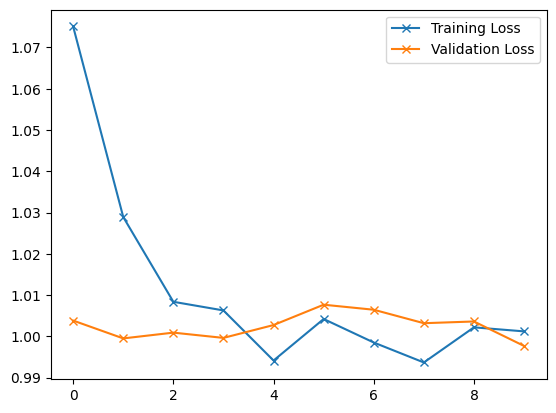

In [14]:
# Train Model with the given params.
np.random.seed(70)  # Set seed for consistentcy
params = {
    'batch_size': 32, 'shuffle': True, 'num_workers': 2
}
train, val = generate_data_loaders(data, params, x_columns, y_columns, 0.8)
model = create_perceptron_model([40, 5, 2, 1])
criterion = nn.MSELoss()
# optimizer = Adam(model.parameters(), lr=0.0009, betas=[0.935, 0.701])
optimizer = SGD(model.parameters(), lr=0.002, momentum=0.95)
# CUDA_VISIBLE is already set to only see one GPU
train_loss, validation_loss = train_model(model, optimizer, criterion, train, val, epochs=10, gpu_to_use=0)
plt.figure()
plt.plot(train_loss, label='Training Loss', marker='x')
plt.plot(validation_loss, label='Validation Loss', marker='x')
# plt.yscale('log')
plt.legend()

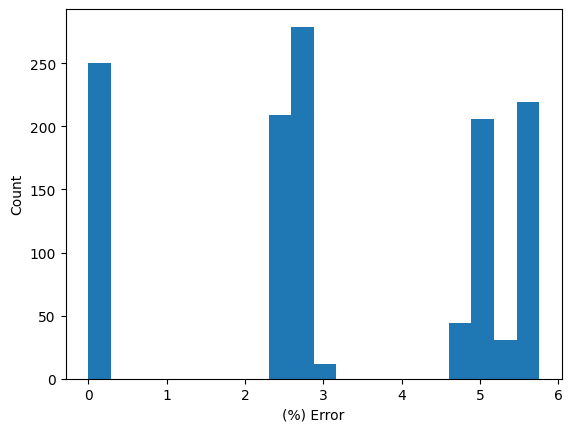

In [13]:
# Get predictions
with torch.no_grad():
    x_data = torch.tensor(data[x_columns].values, dtype=torch.float).cuda()
    predictions = model(x_data)
    predictions = predictions.cpu().numpy()
    predictions = y_scaler.inverse_transform(predictions).flatten()
    y_data = data[y_columns].to_numpy()
    y_data = y_scaler.inverse_transform(y_data).flatten()
    absolute_error = np.abs(y_data - predictions)
    error_df = pd.DataFrame({'Truth': y_data, "Predicted": predictions, "Absolute Error": absolute_error, "%tage": absolute_error/y_data * 100})
plt.figure()
error_df['%tage'].plot.hist(bins=20)
plt.xlabel('(%) Error')
plt.ylabel('Count')
plt.show()

In [22]:
# Top Bad Samples
VIEW_TOP_N = 20
worst_errors = error_df['%tage'].argsort()[::-1][:VIEW_TOP_N]
with pd.option_context("display.max_rows", None):
    display(data[['Maternal Wall Thickness', "Maternal Hb Concentration", "Maternal Saturation", "Fetal Hb Concentration", "Fetal Saturation"]].iloc[worst_errors, :])

,Maternal Wall Thickness,Maternal Hb Concentration,Maternal Saturation,Fetal Hb Concentration,Fetal Saturation
1770,30.0,16.0,-1.414214,17.0,0.900
1765,30.0,16.0,-1.414214,15.5,0.900
1771,30.0,16.0,-1.414214,17.0,0.925
1645,30.0,15.0,-1.414214,17.0,0.900
1829,30.0,16.0,0.707107,11.0,1.000
1760,30.0,16.0,-1.414214,14.0,0.900
1766,30.0,16.0,-1.414214,15.5,0.925
1834,30.0,16.0,0.707107,12.5,1.000
1640,30.0,15.0,-1.414214,15.5,0.900
1772,30.0,16.0,-1.414214,17.0,0.950


In [21]:
# Rough MSE's in percentage
print(f'Train Error(non-normalized): {train_loss[-1] * y_scaler.var_ }')
print(f'Validation Error(non-normalized): {validation_loss[-1] * y_scaler.var_ }')

Train Error(non-normalized): [1.36622606e-05]
Validation Error(non-normalized): [2.11948236e-05]
